In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
print(DEVICE)

cuda


In [3]:
np_x = np.load('./data_feature_all_hour_new.npy').astype(np.float32)
np_y = np.load('./data_feature_all_hour_target.npy').astype(np.float32)
print(np_x.shape)
print(np_y.shape)
train_spilt_index = int(np_x.shape[0] * 0.8)
train_dataset = TensorDataset(torch.from_numpy(np_x[:train_spilt_index]), torch.from_numpy(np_y[:train_spilt_index].reshape(-1,1)))
test_dataset = TensorDataset(torch.from_numpy(np_x[train_spilt_index:]), torch.from_numpy(np_y[train_spilt_index:].reshape(-1,1)))
trainLoader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle = False)
testLoader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = False)

(3768, 48, 184)
(3768,)


In [4]:
class MedicModel(torch.nn.Module):

    def __init__(self) -> None:
        super(MedicModel, self).__init__()
        self.batch_norm = torch.nn.BatchNorm1d(48)
        self.norm1 = torch.nn.LayerNorm(184)
        self.norm2 = torch.nn.LayerNorm(256)
        self.norm3 = torch.nn.LayerNorm(128)
        self.norm4 = torch.nn.LayerNorm(64)
        self.lstm_184 = torch.nn.LSTM(184, 256, batch_first = True)
        self.lstm_128 = torch.nn.LSTM(256, 128, batch_first = True)
        self.lstm_64 = torch.nn.LSTM(128, 64, batch_first = True)
        self.attentionLayer = torch.nn.MultiheadAttention(embed_dim=64, num_heads=1, batch_first=True)
        self.ffn = torch.nn.Sequential(
                torch.nn.Linear(64, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 64)
        )
        self.linear_i = torch.nn.Linear(48 * 64, 60)
        self.linear_o = torch.nn.Linear(60, 1)

    def forward(self,x):
        h = self.batch_norm(x)
        h = self.norm1(x)
        h, (_, _) = self.lstm_184(x)
        h = torch.relu(h)
        h = self.norm2(h)
        h, (_, _) = self.lstm_128(h)
        h = torch.relu(h)
        h = self.norm3(h)
        h, (_, _) = self.lstm_64(h)
        h = torch.relu(h)
        h = self.norm4(h)
        
        atten_out, s = self.attentionLayer(h, h, h)
        h = torch.relu(h)
        h = self.norm4(atten_out + h)
        ffn_out = self.ffn(h)
        h = torch.relu(h)
        h = self.norm4(ffn_out + h)

        h = torch.flatten(h, start_dim=1)
        h = self.linear_i(h)
        h = torch.relu(h)
        h = self.linear_o(h)
        return h

In [5]:
model = MedicModel().to(DEVICE)

In [6]:
opti = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()
losses = []

In [7]:
for epoch in tqdm(range(20)):
    total_loss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        total_loss += loss.item()
    losses.append(total_loss / (len(trainLoader.dataset)//BATCH_SIZE))


100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


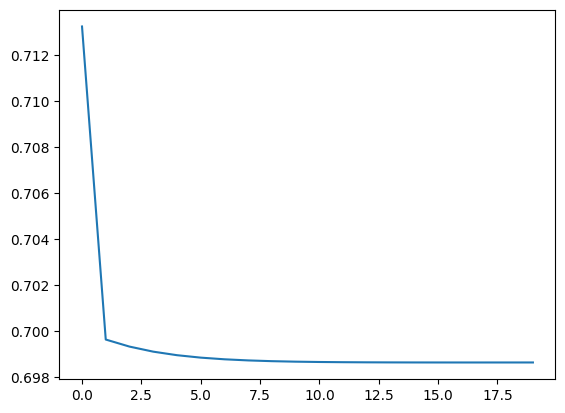

In [8]:
plt.plot(losses)

In [9]:
model.eval()

MedicModel(
  (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm1): LayerNorm((184,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (lstm_184): LSTM(184, 256, batch_first=True)
  (lstm_128): LSTM(256, 128, batch_first=True)
  (lstm_64): LSTM(128, 64, batch_first=True)
  (attentionLayer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (ffn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (linear_i): Linear(in_features=3072, out_features=60, bias=True)
  (linear_o): Linear(in_features=60, out_features=1, bias=True)
)

In [10]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).sum().type(torch.float32)
print(correct.item()/len(trainLoader.dataset))

0.5298606502986065


In [11]:
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).sum().type(torch.float32)
print(correct.item()/len(testLoader.dataset))

0.5291777188328912


In [12]:
class TestModel_1(torch.nn.Module):

    def __init__(self) -> None:
        super(TestModel_1, self).__init__()
        self.laynorm1 = torch.nn.LayerNorm(184)
        self.attn1 = torch.nn.MultiheadAttention(184, num_heads = 1, batch_first = True)
        self.ffn1 = torch.nn.Sequential(
            torch.nn.Linear(184, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64)
        )
        self.laynorm2 = torch.nn.LayerNorm(64)
        self.attn2 = torch.nn.MultiheadAttention(64, num_heads = 1, batch_first = True)
        self.ffn2 = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16)
        )
        self.outlayer = torch.nn.Linear(48 * 16, 1) 
    def forward(self, x):
        attn_out , _ = self.attn1(x, x, x)
        h = self.laynorm1(attn_out + x)
        h = self.ffn1(h)
        
        attn_out , _ = self.attn2(h, h, h)
        h = self.laynorm2(attn_out + h)
        h = self.ffn2(h)
        h = torch.flatten(h, start_dim=1)
        o = self.outlayer(h)
        return o

In [13]:
model_2 = TestModel_1().to(DEVICE)
optimizer = torch.optim.Adam(model_2.parameters(), lr = 1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()
losses = []
for epoch in tqdm(range(100)):
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        pred = model_2(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


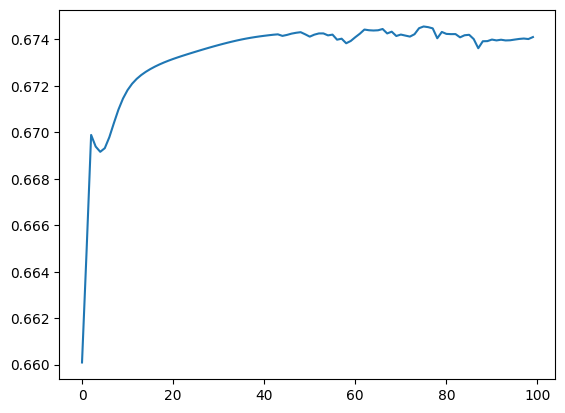

In [14]:
plt.plot(losses)

In [15]:
model_2.eval()

TestModel_1(
  (laynorm1): LayerNorm((184,), eps=1e-05, elementwise_affine=True)
  (attn1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=184, out_features=184, bias=True)
  )
  (ffn1): Sequential(
    (0): Linear(in_features=184, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (laynorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (ffn2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (outlayer): Linear(in_features=768, out_features=1, bias=True)
)

In [16]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model_2(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).sum().type(torch.float32)
print(correct.item()/len(trainLoader.dataset))

0.5298606502986065


In [17]:
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model_2(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).sum().type(torch.float32)
print(correct.item()/len(testLoader.dataset))

0.5291777188328912
